In [1]:
from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class FER2013Dataset(Dataset):
    "Face Expression Recognition Dataset"
    
    def __init__(self, file_path):
        """
        Args:
            file_path (string): Path to the csv file with emotion, pixel & usage.
        """
        self.file_path = file_path
        self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # Define the name of classes / expression
        
        with open(self.file_path) as f: # read all the csv using readlines
            self.data = f.readlines()
            
        self.total_images = len(self.data) - 1 #reduce 1 for row of column

    def __len__(self):  
        return self.total_images
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        with open(fer_path) as f:
            idx ,emotion, img = self.data[idx + 1].split(",") #plus 1 to skip first row (column name)
            
        emotion = int(emotion) # just make sure it is int not str
        img = img.split(" ") # because the pixels are seperated by space
        img = np.array(img, 'float') # just make sure it is int not str
        img = img.reshape(48,48) # change shape from 2304 to 48 * 48

        
        return img,emotion
    

In [3]:
fer_path = 'fer2013.csv'

In [4]:
data = pd.read_csv(fer_path)
val,test,train =  [x for _, x in data.groupby(data['Usage'])]
train.reset_index()[['emotion', 'pixels']].to_csv('train.csv')
test.reset_index()[['emotion', 'pixels']].to_csv('test.csv')
val.reset_index()[['emotion', 'pixels']].to_csv('val.csv')



In [5]:
train.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
trainset = FER2013Dataset('train.csv')
testset = FER2013Dataset('test.csv')
valset = FER2013Dataset('val.csv')

trainset[1000] # RETURN IMAGE and EMOTION of row 1000

(array([[ 47.,  42.,  40., ...,  25.,  29.,  56.],
        [ 40.,  39.,  52., ...,  21.,  32.,  65.],
        [ 47.,  82., 103., ...,  48.,  40.,  47.],
        ...,
        [199., 246., 236., ..., 117., 107., 100.],
        [238., 239., 237., ..., 163., 139., 110.],
        [234., 239., 230., ..., 189., 162., 147.]]), 6)

In [7]:
from PIL import Image
image , emotion = trainset[1000]


In [8]:
from torchvision import transforms

In [9]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32,shuffle=True)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.fc1 = nn.Linear(2304,500)
        self.fc2 = nn.Linear(500,500)
        self.fc3 = nn.Linear(500,100)
        self.fc4 = nn.Linear(100,50)

        self.fc5 = nn.Linear(50,7)
        
        self.dp= nn.Dropout(0.3)
        self.dp1= nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        ## Define forward behavior
        x=F.relu(self.fc1(x))
        x=self.dp1(F.relu(self.fc2(x)))
        x=self.dp(F.relu(self.fc3(x)))
        x=self.dp(F.relu(self.fc4(x)))

        x=F.log_softmax(self.fc5(x), dim=1)
        return x
model_scratch = Net()
print(model_scratch)

Net(
  (fc1): Linear(in_features=2304, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=7, bias=True)
  (dp): Dropout(p=0.3, inplace=False)
  (dp1): Dropout(p=0.2, inplace=False)
)


In [20]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model_scratch.parameters(), lr=0.002)

In [33]:
use_cuda = torch.cuda.is_available()

classes = (['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'])

In [30]:
def train(n_epochs,model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                model = model.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data.float())
            loss =criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
        
       ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                model = model.cuda()
            ## update the average validation loss
            optimizer.zero_grad()
            output = model(data.float())
            loss = criterion(output,target)
            #valid_loss += loss.item()*data.size(0)
            #valid_loss = valid_loss/len(validset)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        

    # return trained model
    return model


# train the model
model_scratch = train(30, model_scratch, optimizer, criterion, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 1.684626 	Validation Loss: 1.643330
Validation loss decreased (inf --> 1.643330).  Saving model ...
Epoch: 2 	Training Loss: 1.681592 	Validation Loss: 1.638374
Validation loss decreased (1.643330 --> 1.638374).  Saving model ...
Epoch: 3 	Training Loss: 1.677788 	Validation Loss: 1.638307
Validation loss decreased (1.638374 --> 1.638307).  Saving model ...
Epoch: 4 	Training Loss: 1.674177 	Validation Loss: 1.632358
Validation loss decreased (1.638307 --> 1.632358).  Saving model ...
Epoch: 5 	Training Loss: 1.669474 	Validation Loss: 1.631369
Validation loss decreased (1.632358 --> 1.631369).  Saving model ...
Epoch: 6 	Training Loss: 1.669191 	Validation Loss: 1.641016
Epoch: 7 	Training Loss: 1.663249 	Validation Loss: 1.628174
Validation loss decreased (1.631369 --> 1.628174).  Saving model ...
Epoch: 8 	Training Loss: 1.661204 	Validation Loss: 1.620802
Validation loss decreased (1.628174 --> 1.620802).  Saving model ...
Epoch: 9 	Training Loss: 1.654209 

In [31]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 0)))

In [34]:
def test( model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(model_scratch, criterion, use_cuda)

Test Loss: 1.564611


Test Accuracy: 39% (1420/3589)


In [25]:
test_images, labels = next(iter(test_loader))

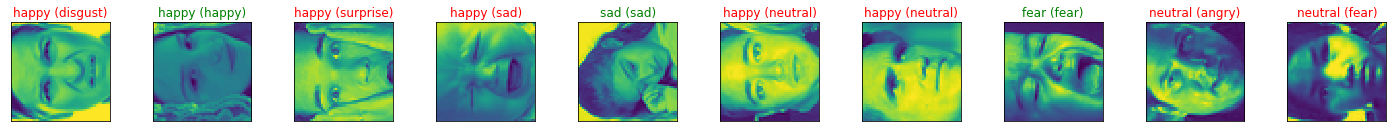

In [26]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_scratch(images.float())
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))